In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def ShowImage(img, gray):
    plt.axis("off")
    if gray:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.show()
    
def normalization(shade, scale):
    mn, mx = np.amin(shade), np.amax(shade)
    return (((shade - mn)/(mx-mn))*scale).astype(np.uint8)
    

In [3]:
def cv2_show(caption, im):
    cv2.imshow(caption,im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
def split_sub_image(img):
    # print(img.shape)
    h, w = img.shape
    w_cutoff = w // 2
    img_left = img[:,:w_cutoff]
    img_right = img[:,w_cutoff:]
    return img_left, img_right 

In [5]:
def hist_img_v0(f):
    m, n = f.shape
    h = [0.0] * 256
    for i in range(m):
        for j in range(n):
            h[f[i, j]]+=1
    return np.array(h, dtype='uint16')

In [6]:
def rgb_to_hsi(img):
    R = img[:, :, 2].astype(np.float16)
    G = img[:, :, 1].astype(np.float16)
    B = img[:, :, 0].astype(np.float16)

    I = (R + G + B) / 3.0

    min_rgb = np.minimum.reduce([R, G, B])
    epsilon = 1e-6
    # S = 1 - (3.0 / (R + G + B + 1e-6)) * min_rgb * min_rgb # overflow
    S = 1 - (3.0 / np.clip(R + G + B, epsilon, None, dtype=np.float64)) * min_rgb

    num = 0.5 * ((R - G) + (R - B))
    den = np.sqrt((R - G)**2 + (R - B) * (G - B))
    den[den == 0] = 0.0000001  
    theta = np.arccos(num / den)

    H = theta
    H[B > G] = 2 * np.pi - H[B > G]
    H = np.degrees(H)
    return H,S,I

In [7]:
def delete_noise(img):
    mask = np.ones([3, 3], dtype = 'float16') 
    mask = mask/9
    print(mask)
    f = img.copy().astype(np.float16)
    (m,n) = img.shape
    out = np.zeros_like(img, dtype = 'float16')

    for i in range(1,m-1):
        for j in range(1,n-1):
            tmp = 0
            for p in range(3):
                for q in range(3):
                    tmp = tmp + (mask[p,q]*f[i+p-1,j+q-1])
            out[i,j] = tmp   
    return out.astype(np.uint8)

In [8]:
def intermean(hist, t, st, en):
    tot = np.sum(hist[st:en])
    prob = hist/tot
    w0 = np.sum(prob[st:t+1]) + 0.0000001
    #w1 = np.sum(prob[t+1:en])
    w1 = (1 - w0) +  + 0.0000001
    i0 = np.array([i for i in range(st,t+1)])
    i1 = np.array([i for i in range(t+1, en)])
    u0 = np.sum(i0*prob[st:t+1])/w0
    u1 = np.sum(i1*prob[t+1:en])/w1
    if u0 == 0.0:
        thr = u1
    elif u1 == 0.0:
        thr = u0
    else:
        thr = (u0+u1)/2
    return thr.astype(np.uint8)    

In [9]:
img = cv2.imread('./images/color.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

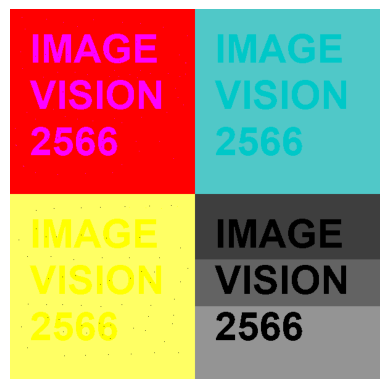

In [10]:
ShowImage(img_rgb, False)

In [11]:
H, S, I = rgb_to_hsi(img_rgb)
print(np.amax(H),np.amax(S),np.amax(I))

h_norm, s_norm, i_norm = normalization(H, 255), normalization(S, 255), normalization(I, 255)
print(np.amax(h_norm),np.amax(s_norm),np.amax(i_norm))

300.0 1.0 203.4
255 255 255


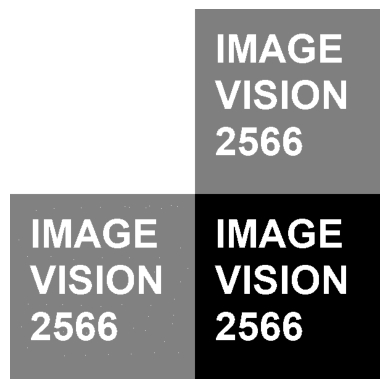

In [12]:
ShowImage(s_norm, 1)

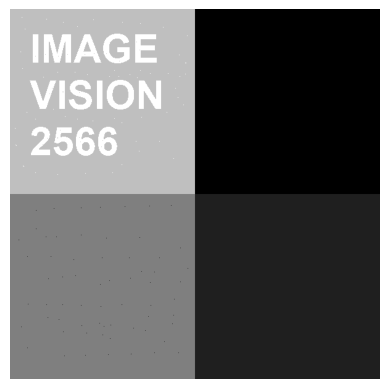

In [13]:
ShowImage(h_norm, 1)

### Split

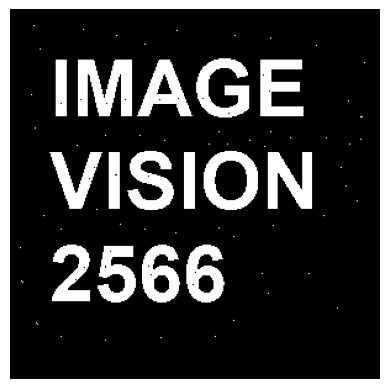

In [14]:
sub1, sub2 = split_sub_image(h_norm)
sub1_1, sub1_2 = split_sub_image((sub1.transpose()))
sub1_1 = sub1_1.transpose()
ShowImage(sub1_1, 1)

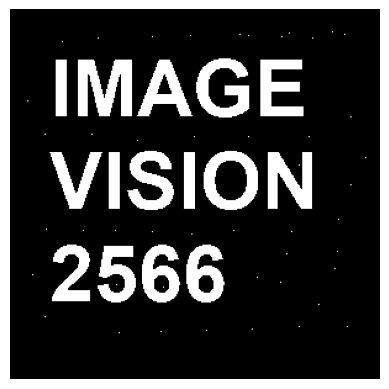

In [15]:
sub1, sub2 = split_sub_image(s_norm)
sub1, sub1_2 = split_sub_image((sub1.transpose()))
sub1_2 = sub1_2.transpose()
ShowImage(sub1_2, 1)

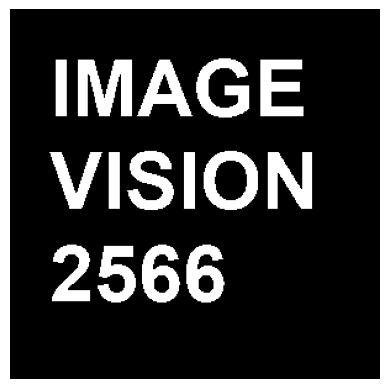

In [16]:
sub1, sub2 = split_sub_image(s_norm)
sub2_1, sub2_2 = split_sub_image((sub2.transpose()))
sub2_1 = sub2_1.transpose()
ShowImage(sub2_1, 1)

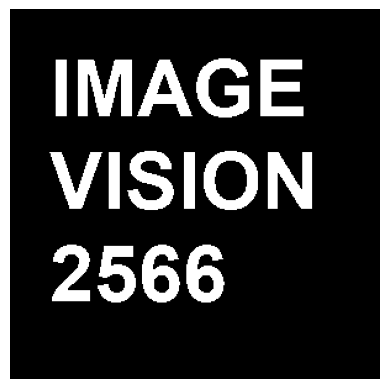

In [17]:
sub2_2 = sub2_2.transpose()
ShowImage(sub2_2, 1)

#### result sub1_1

[[0.1111 0.1111 0.1111]
 [0.1111 0.1111 0.1111]
 [0.1111 0.1111 0.1111]]


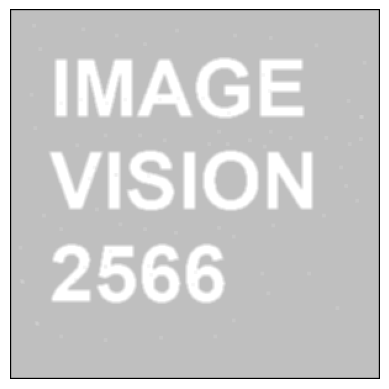

In [18]:
df = delete_noise(sub1_1)
ShowImage(df, 1)

In [19]:
hist = hist_img_v0(df)
tol = 1
st, en = 0, 256
for t in range(1):
    flag = True
    T = []
    #t0 = random.randint(st, en)
    t0 = int((st+en)*0.5)
    T.append(t0)
    while(flag):
        t1 = intermean(hist[st:en], t0, st, en)
        T.append(t1)
        #print(t0, t1)
        if abs(t1-t0) < tol :
            flag = False
        else:
            t0 = t1
    thr = T[-1]
    en = thr+1
    print(T, thr)

[128, 226, 214, 211, 205, 205] 205


/var/folders/3j/472my0ns69l6cvybqf8h17sm0000gn/T/ipykernel_26582/1165929339.py:14: RuntimeWarning: overflow encountered in scalar subtract
  if abs(t1-t0) < tol :


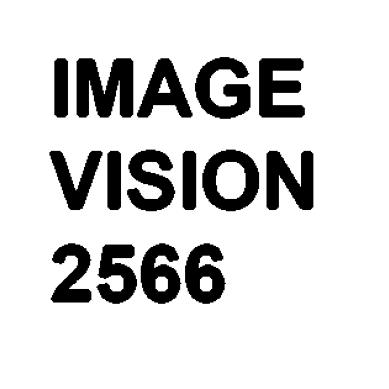

In [20]:
result_sub1_1 = np.zeros_like(sub1_1)
# result_sub2_1[sub2_1 > 150] = 0
result_sub1_1[df <= thr] = 255
ShowImage(result_sub1_1, 1)

#### result sub1_2

[[0.1111 0.1111 0.1111]
 [0.1111 0.1111 0.1111]
 [0.1111 0.1111 0.1111]]


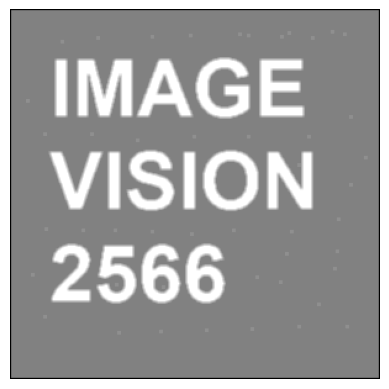

In [21]:
df = delete_noise(sub1_2)
ShowImage(df, 1)

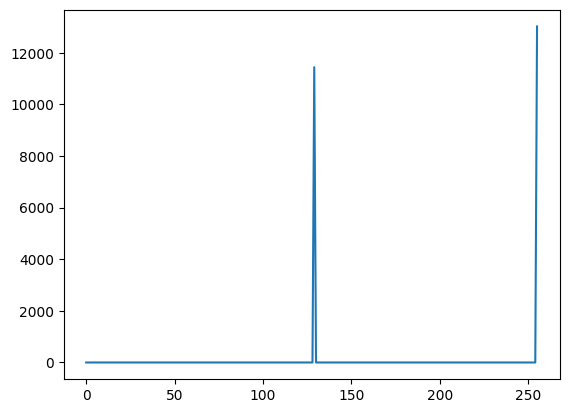

In [22]:
hist = hist_img_v0(sub1_2)
plt.plot(hist)

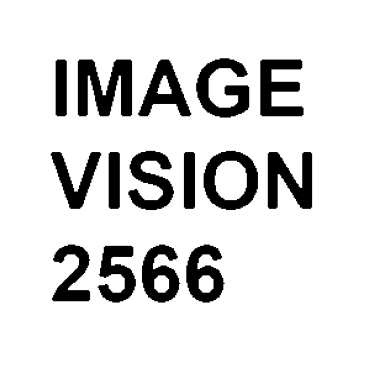

In [23]:
result_sub1_2 = np.zeros_like(sub1_2)
# result_sub2_1[sub2_1 > 150] = 0
result_sub1_2[df <= 200] = 255
ShowImage(result_sub1_2, 1)

#### result sub2_1

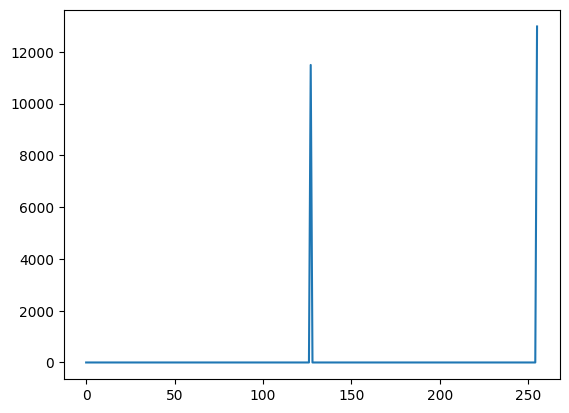

In [24]:
hist = hist_img_v0(sub2_1)
plt.plot(hist)

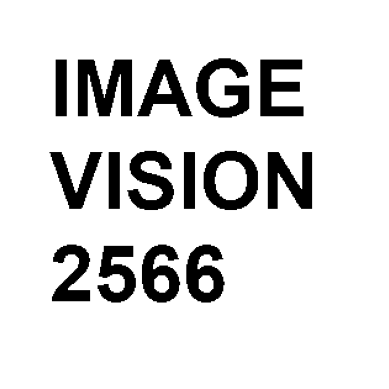

In [25]:
result_sub2_1 = np.zeros_like(sub2_1)
result_sub2_1[sub2_1 <= 200] = 255
ShowImage(result_sub2_1, 1)

#### result sub2_2

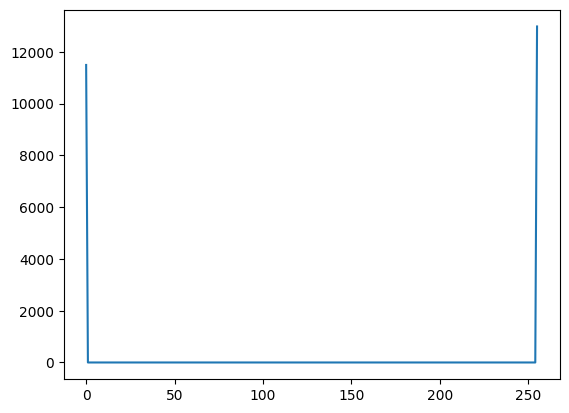

In [26]:
hist = hist_img_v0(sub2_2)
plt.plot(hist)

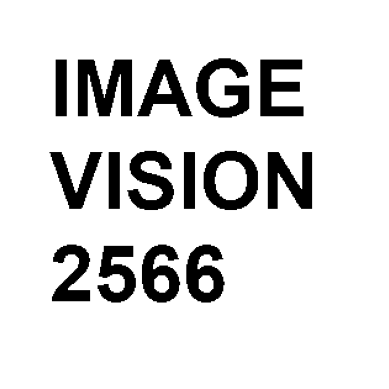

In [27]:
result_sub2_2 = np.zeros_like(sub2_2)
result_sub2_2[sub2_2 <= 125] = 255
ShowImage(result_sub2_2, 1)

### Merge

In [28]:
final_result = np.zeros_like(h_norm, dtype='uint8')
h, w = h_norm.shape
wc, hc = w // 2, h // 2
final_result[:hc,:wc] = result_sub1_1
final_result[hc:,:wc] = result_sub1_2
final_result[:hc,wc:] = result_sub2_1
final_result[hc:,wc:] = result_sub2_2

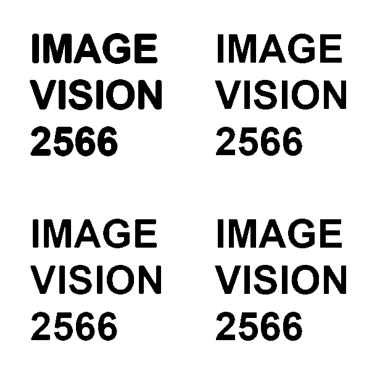

In [29]:
plt.axis('off')
plt.imshow(final_result, cmap='gray')
plt.savefig('./outs/hw4_HSI.png')